# Production optimisation with ensembles – an interactive tutorial

Copyright Patrick N. Raanes, NORCE, 2023.

This is a self-contained tutorial on production optimisation using ensemble methods.
- Please have a look at the [history matching (HM) tutorial](HistoryMatch.ipynb)
  for an introduction to Python, Jupyter notebooks, and this reservoir simulator.

TODO:
- Handle set_perm so it's not necessary to put into new_mod
- 1D: Plot ensemble of npv curves
- Plot ensemble of pdfs of npvs, including
  strategies: reactive control, nominal optimization, robust optimization
- Use model with many injectors, producers ? jansen2010closed_prez
- Cite essen, jansen, chen, fonseca, stordal, raanes

If you're on **Google Colab**, run the cell below to install the requirements.
Otherwise (and assuming you have done the installation described in the README),
you can skip/delete this cell.

In [1]:
remote = "https://raw.githubusercontent.com/patnr/HistoryMatching"
!wget -qO- {remote}/master/colab_bootstrap.sh | bash -s

Not running on Colab => Didn't do anything.


## Imports

In [2]:
import copy
from dataclasses import dataclass

In [3]:
import numpy as np
from tqdm.auto import tqdm
import numpy.random as rnd
import TPFA_ResSim as simulator
from mpl_tools.place import freshfig
from struct_tools import DotDict as Dict

In [4]:
import tools.plotting as plotting
from tools import geostat, utils, mpl_setup
from tools.utils import apply

In [5]:
mpl_setup.init()
np.set_printoptions(precision=6)

Could put this in npv() rather than copying the base model
but it's useful to have a base model in the global namespace
for plotting purposes.

## Define model
We start with the same settings as in the previous tutorial (on history matching).

In [6]:
model = simulator.ResSim(Nx=20, Ny=20, Lx=2, Ly=1)

In [7]:
def sample_prior_perm(N):
    lperms = geostat.gaussian_fields(model.mesh, N, r=0.8)
    return lperms

In [8]:
def perm_transf(x):
    return .1 + np.exp(5*x)

In [9]:
def set_perm(model, log_perm_array):
    """Set perm. in model code (both x and y components)."""
    p = perm_transf(log_perm_array)
    p = p.reshape(model.shape)
    model.Gridded.K = np.stack([p, p])

In [10]:
seed = rnd.seed(3)
pperm = sample_prior_perm(1)
set_perm(model, pperm)

Suggested total rate of production (total rate of injection must be the same).

In [11]:
rate0 = 1.5

List of coordinates (x, y) of the 4 cornerns of the rectangular domain

In [12]:
xy_4corners = np.dstack(np.meshgrid(
    np.array([.12, .87]) * model.Lx,
    np.array([.12, .87]) * model.Ly,
)).reshape((-1, 2))

We'll be altering the model quite a lot,
so let's make a convenient factory function.

In [13]:
def new_mod(**kwargs):
    """Create new model, based on `globals()['model']`."""
    # Init
    new = copy.deepcopy(model)  # dont overwrite
    # Set attrs from kwargs
    for key, val in kwargs.items():
        setattr(new, key, val)
    # Sanitize
    new.config_wells(new.inj_xy, new.inj_rates,
                     new.prod_xy, new.prod_rates)
    return new

This will serve as our default model

In [14]:
model = new_mod(
    name = "Base model",
    inj_xy  = [[model.Lx/2, model.Ly/2]],
    prod_xy = xy_4corners,
    inj_rates  = rate0 * np.ones((1, 1)) / 1,
    prod_rates = rate0 * np.ones((4, 1)) / 4,
)

The global `model` is used by `new_mod` for defaults.
Let's store its current state

In [15]:
model0 = new_mod()

Plot

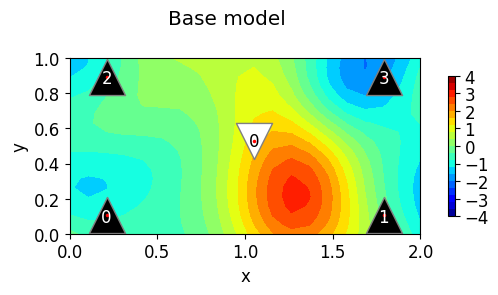

In [16]:
fig, ax = freshfig(model.name, figsize=(1, .6), rel=True)
model.plt_field(ax, pperm, "pperm", wells=True, colorbar=True);
fig.tight_layout()

## Define simulation

In [18]:
wsat0 = np.zeros(model.Nxy)
T = 1
dt = 0.025
nTime = round(T/dt)

Multiprocessing. Only used in ensemble runs (ref. `apply`)

In [19]:
utils.nCPU = True

Like `forward_model` of the previous (history matching) tutorial, but w/o setting params

In [17]:
def sim(model, wsat, pbar=False, leave=False):
    """Simulate reservoir."""
    integrator = model.time_stepper(dt)
    wsats = simulator.recurse(integrator, nTime, wsat, pbar=pbar, leave=leave)
    # Extract production time series from water saturation fields
    wells = model.xy2ind(*model.prod_xy.T)
    prods = np.array([wsat[wells] for wsat in wsats])
    return wsats, prods

In [20]:
def plot_final_sweep(model):
    """Simulate reservoir, plot final oil saturation."""
    title = plotting.dash_join(f"Final sweep", getattr(model, "name", ""))
    wsats, prods = sim(model, wsat0)
    fig, ax = freshfig(title, figsize=(1, .6), rel=True)
    model.plt_field(ax, wsats[-1], "oil", wells=True, colorbar=True)
    fig.tight_layout()

Let us plot the final sweep given these well settings

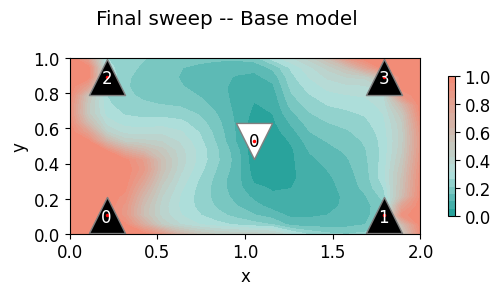

In [21]:
plot_final_sweep(model)

## EnOpt
`EnGrad` uses LLS regression to estimate gradients.

In [22]:
def EnGrad(obj, u, chol, nEns, precond=False):
    """Compute ensemble gradient for `obj` centered on `u`."""
    U, _ = utils.center(rnd.randn(nEns, len(u)) @ chol.T)
    J, _ = utils.center(obj(u + U))
    if precond:
        g = U.T @ J / (nEns-1)
    else:
        g = utils.rinv(U, reg=.1, tikh=True) @ J
    return g

*EnOpt*: Gradient descent using `EnGrad`.
- `rtol` specified how large an improvement is required to update the iterate.
  Large values makes backtracking more reluctant to accept an update,
  resulting in *faster* declaration of convergence.
  Setting to 0 is not recommended, because if the objective function is flat
  in the neighborhood, then the path could just go in circles on that flat.

In [23]:
def EnOpt(
    # Objective function, initial guess, cholesky factor for sampling ens:
    obj, u, chol,
    # Minimize or maximize:
    sign=+1,
    # Ensemble size
    nEns=10,
    # Step modifiers:
    normed=True, precond=False,
    # Backtracking (step lenghts):
    xSteps=tuple(.4 * 1/2**i for i in range(8)),
    # Stopping criteria:
    nIter=100, rtol=1e-8
):
    """Gradient/steepest *descent* using ensemble (LLS) gradient and backtracking."""

    def backtrack(base_step):
        """Line search by bisection."""
        with tqdm(total=len(xSteps), desc="Backtrack", leave=False) as pbar:
            for i, xStep in enumerate(xSteps):
                pbar.update(1)
                x = path[-1] + sign * xStep * base_step
                J = obj(x)
                if sign*(J - objs[-1]) > atol:
                    pbar.update(len(xSteps))  # needed in Jupyter
                    return x, J, i

    J = obj(u)
    atol = max(1e-8, abs(J)) * rtol
    info, path, objs = {}, [], []

    for itr in range(nIter):
        path.append(u)
        objs.append(J)

        # Compute search direction
        grad = EnGrad(obj, u, chol, nEns, precond=precond)
        if normed:
            grad /= utils.mnorm(grad)

        # Update iterate
        if not (updated := backtrack(grad)):
            # Stop if lower J not found
            status = "Converged ✅"
            break
        u, J, i = updated
        info.setdefault('nDeclined', []).append(i)

    else:
        status = "Ran out of iters ❌"

    print(f"{status:<9} {itr=:<5}  {path[-1]=}  {objs[-1]=:.2f}")
    return np.array(path), np.array(objs), info

## NPV

Convert production saturations to monetary value.

In [24]:
def prod2npv(model, prods):
    """Net present value (NPV), i.e. discounted, total oil production."""
    discounts = .99 ** np.arange(nTime + 1)
    prods = 1 - prods                   # water --> oil
    prods = prods * model.prod_rates.T  # volume = saturation * rate
    prods = np.sum(prods, -1)           # sum over wells
    value = prods @ discounts           # sum in time, incld. discount factors
    # Compute cost of water injection
    # PS: We don't bother with cost of water production,
    # since it is implicitly approximated by reduction in oil production.
    inj_rates = model.inj_rates
    if inj_rates.shape[1] == 1:
        inj_rates = np.tile(inj_rates, (1, nTime))
    cost = np.sum(inj_rates, 0)
    cost = cost @ discounts[:-1]
    return value - .5*cost

Objective function consists of model config, simulation, and conversion to money.

In [25]:
def npv(**kwargs):
    """NPV from model config."""
    try:
        model = new_mod(**kwargs)
        wsats, prods = sim(model, wsat0)
    except Exception:
        return 0  # Invalid model params. Penalize.
        # Use `raise` for debugging.
    return prod2npv(model, prods)

## Optimize x-coordinate of single injector
Let's try it out with a 1D optimisation case
Input shape `(nEns, 1)` or `(1,)`.

In [26]:
def npv_in_x_of_inj0_with_fixed_y(x):
    """Optimize x coordinate of injector."""
    xs, singleton = utils.atleast_2d(x)
    ys = np.full_like(xs, y)
    xys = np.dstack([xs, ys])
    Js = apply(npv, inj_xy=xys, unzip=False,
               pbar=not singleton, leave=False)
    return Js[0] if singleton else Js

In [27]:
y = model.Ly/2
obj = npv_in_x_of_inj0_with_fixed_y

Compute entire objective

In [28]:
xx = np.linspace(0, model.Lx, 201)
npvs = obj(np.atleast_2d(xx).T)

npv's:   0%|          | 0/201 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=2      path[-1]=array([0.9])  objs[-1]=17.38


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.8])  objs[-1]=17.94


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=1      path[-1]=array([0.8])  objs[-1]=17.94


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=2      path[-1]=array([0.8])  objs[-1]=17.94


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.8])  objs[-1]=18.34


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.7])  objs[-1]=18.34


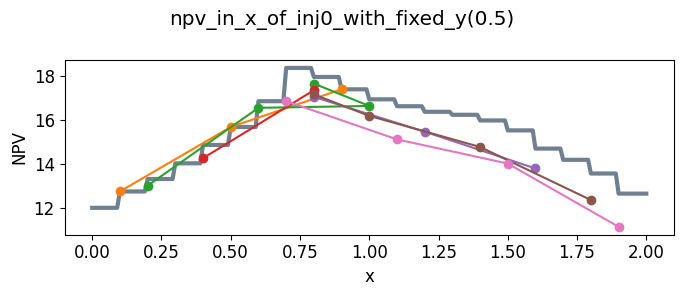

In [29]:
# Plot objective
fig, ax = freshfig(f"{obj.__name__}({y})", figsize=(7, 3))
ax.set(xlabel="x", ylabel="NPV")
ax.plot(xx, npvs, "slategrey", lw=3)

# Optimize, plot
chol = .3 * np.eye(1)
shifts = {}
u0s = model.Lx * np.array([[.05, .1, .2, .8, .9, .95]]).T
for i, u0 in enumerate(u0s):
    path, objs, info = EnOpt(obj, u0, chol)
    shift = .3*i  # for visual distinction
    ax.plot(path, objs - shift, '-o', c=f'C{i+1}')
fig.tight_layout()

## Optimize both coordinates
Input shape `(nEns, 2*nInj)`.

In [30]:
def npv_in_injectors(xys):
    """`npv(inj_xy)`."""
    xys, singleton = utils.atleast_2d(xys)
    xys = xys.reshape((len(xys), -1, 2))  # (nEns, 2*nInj) --> (nEns, nInj, 2)
    Js = apply(npv, inj_xy=xys, unzip=False,
               pbar=not singleton, leave=False)
    return Js[0] if singleton else Js

Compute entire objective

In [31]:
obj = npv_in_injectors
X, Y = model.mesh
XY = np.vstack([X.ravel(), Y.ravel()]).T
npvs = obj(XY)

npv's:   0%|          | 0/400 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.701015, 0.418363])  objs[-1]=18.21


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=5      path[-1]=array([0.759273, 0.419112])  objs[-1]=18.21


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.735608, 0.37764 ])  objs[-1]=17.85


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=4      path[-1]=array([0.783101, 0.446365])  objs[-1]=18.21


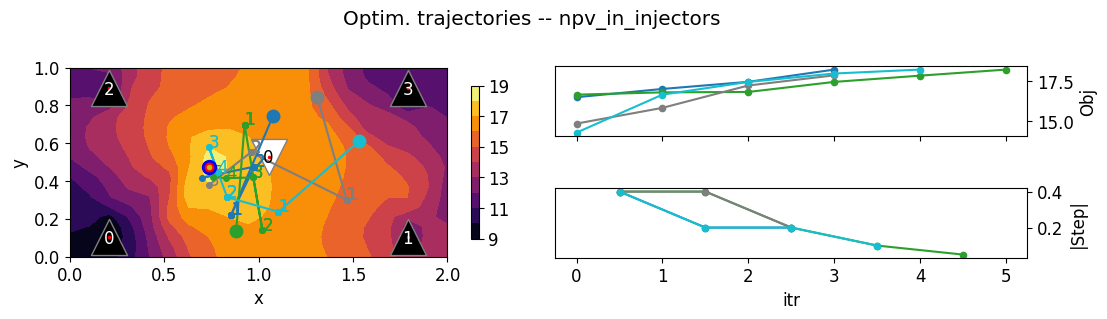

In [32]:
# Plot objective
fig, axs = plotting.figure12(obj.__name__)
model.plt_field(axs[0], npvs, "NPV", wells=True, argmax=True, colorbar=True);
fig.tight_layout()

# Optimize, plot
chol = .1 * np.eye(2)
for color in ['C0', 'C2', 'C7', 'C9']:
    u0 = rnd.rand(2) * model.domain[1]
    path, objs, info = EnOpt(obj, u0, chol)
    plotting.add_path12(*axs, path, objs, color=color)

##### Comments
- Given the zig-zag optimization trajectories we see, it would appear
  that the EnOpt gradient descent implementation could well benefit
  from using an "acceleration" technique such as "momentum".
  See git commit `9937d5b2` for a working implementation.
- Some get stuck in local minima
- Smaller steps towards end
- Notice that discreteness of npv_in_injectors function means that
  they dont all CV to exactly the same

Plot of final sweep

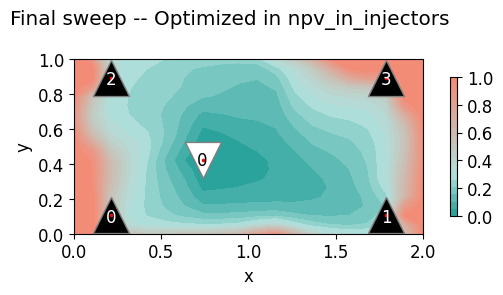

In [33]:
model = new_mod(inj_xy=path[-1].reshape((-1, 2)),
                name=f"Optimized in {obj.__name__}")
plot_final_sweep(model)

## Optimize coordinates of 2 injectors

With 2 injectors, it's more interesting (not necessary) to also only have 2 producers. So let's configure our model for that.

In [34]:
model = new_mod(
    name = "Lower 2 corners",
    prod_xy = xy_4corners[:2],
    inj_xy  = model.inj_xy[:2], # dummy
    prod_rates = rate0 * np.ones((2, 1)) / 2,
    inj_rates  = rate0 * np.ones((2, 1)) / 2,
)

As you might imagine, with the 2 producers at the lower corners,
the optimal 2 injector positions will be somewhere near the upper edge.
But boundaries are a problem for basic EnOpt.
Because of its Gaussian character, it will often sample points outside of the domain.
This won't crash our optimisation, since the `npv` function penalizes invalid models,
but the gradient near the border will seem to indicate that the border is a bad place to be,
which is not necessarily the case.

- One quickfix to this problem
(but more technically challenging that the penalization already in place)
is to truncate the ensemble members to the valid domain.
- Another alternative (ref. Mathias) is to use a non-Gaussian generalisation of EnOpt that samples
from a Beta (e.g.) distribution, and uses a different formula than LLS regression
to estimate the average gradient.
- Another alternative is to transform the control variables
so that the domain is the whole of $\mathcal{R}^d$.
This is the approach taken below.

In [35]:
def transform_xys(xys):
    """Transform infinite plane to `(0, Lx) x (0, Ly)`."""
    def realline_to_0L(x, L, compress=1):
        sigmoid = lambda z: 1/(1 + np.exp(-z))  # noqa
        x = (x - L/2) * L * compress
        return L * sigmoid(x)

    xys = np.array(xys, dtype=float)

    # Loop over (x, y)
    for i0, L in zip([0, 1], model.domain[1]):
        ii = slice(i0, None, 2)
        xys[..., ii] = realline_to_0L(xys[..., ii], L, 1)
    return xys

In [36]:
def npv_in_injectors_transformed(xys):
    return npv_in_injectors(transform_xys(xys))

obj = npv_in_injectors_transformed

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=9      path[-1]=array([0.604071, 2.923708, 2.280215, 3.153044])  objs[-1]=21.30


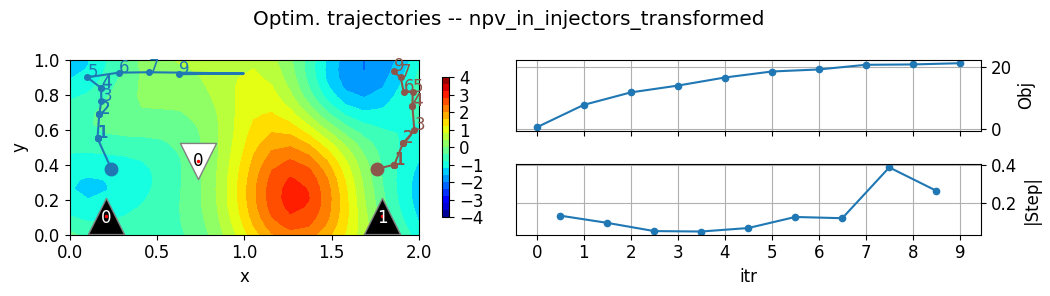

In [37]:
# Plot perm field
fig, axs = plotting.figure12(obj.__name__)
model.plt_field(axs[0], pperm, "pperm", wells=True, colorbar=True)

# Optimize
u0 = np.array([0, 0] + [2, 0])
chol = .1 * np.eye(len(u0))
path, objs, info = EnOpt(obj, u0, chol)
path = transform_xys(path)

# Plot optimisation trajectory
plotting.add_path12(*axs, path[:, :2], objs, color='C0')
plotting.add_path12(*axs, path[:, 2:], color='C5')
fig.tight_layout()

Let's plot the final sweep

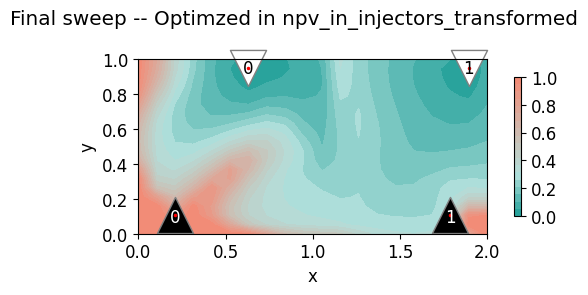

In [38]:
model = new_mod(inj_xy=path[-1].reshape((-1, 2)),
                name=f"Optimzed in {obj.__name__}")
plot_final_sweep(model)

## Optimize single rate

When setting the injection rate(s), we must also
set the total production rates to be the same (this is a model constraint).
When there are multiple producers, we could distribute the production
differently across the wells (somehow, our choice),
but here we all set them all to be equal.

In [39]:
def npv_in_rates(inj_rates):
    """`npv(inj_rates)`."""
    inj_rates, singleton = utils.atleast_2d(inj_rates)
    nEns = len(inj_rates)
    inj_rates = inj_rates.reshape((nEns, -1, 1))  # (nEns, nInj) --> (nEns, nInj, 1)
    total_rate = np.sum(inj_rates, axis=1).squeeze()  # (nEns,)
    nProd = len(model.prod_rates)
    prod_rates = (np.ones((1, nProd, nEns)) * total_rate/nProd).T
    Js = apply(npv, inj_rates=inj_rates, prod_rates=prod_rates, unzip=False,
               pbar=not singleton, leave=False)
    return Js[0] if singleton else Js

obj = npv_in_rates

Note: input shape `(nEns, nInj)`.

Restore default well config

In [40]:
model = model0

Optimize

npv's:   0%|          | 0/21 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=6      path[-1]=array([1.75])  objs[-1]=17.29


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=11     path[-1]=array([1.753125])  objs[-1]=17.29


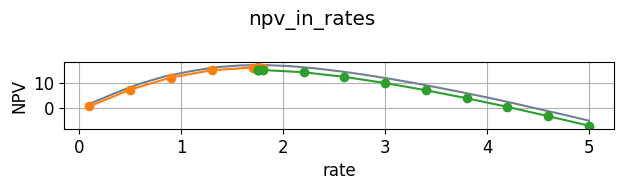

In [41]:
xx = np.linspace(0.1, 5, 21)
npvs = obj(np.atleast_2d(xx).T)

fig, ax = freshfig(obj.__name__, figsize=(1, .4), rel=True)
ax.grid()
ax.set(xlabel="rate", ylabel="NPV")
ax.plot(xx, npvs, "slategrey")

for i, u0 in enumerate(np.array([[.1, 5]]).T):
    chol = .1 * np.eye(len(u0))
    path, objs, info = EnOpt(obj, u0, chol)
    shift = i+1  # for visual distinction
    ax.plot(path, objs - shift, '-o', color=f'C{i+1}')
fig.tight_layout()

## Interactive (manual) optimisation of multiple rates

Let's make the flow "less orthogonal" by not placing the wells on a rectilinear grid (i.e. the 4 corners).

In [42]:
triangle = [0, 135, -135]
wells = dict(
    inj_xy = ([[model.Lx/2, model.Ly/2]] +
              [utils.xy_p_normed(th + 90, *model.domain[1]) for th in triangle]),
    prod_xy = [utils.xy_p_normed(th - 90, *model.domain[1]) for th in triangle],
    inj_rates  = rate0 * np.ones((4, 1)) / 4,
    prod_rates = rate0 * np.ones((3, 1)) / 3,
)
model = new_mod(**wells)

Show well config

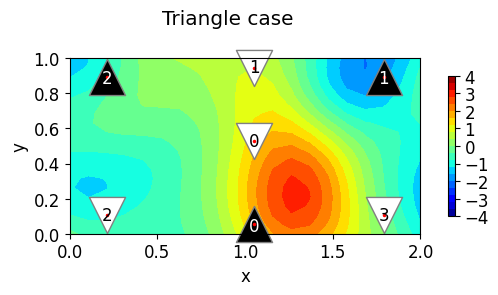

In [43]:
fig, ax = freshfig("Triangle case", figsize=(1, .6), rel=True)
model.plt_field(ax, pperm, "pperm", wells=True, colorbar=True);
fig.tight_layout()

Define function that takes injection rates and computes final sweep, i.e. saturation field.

In [44]:
def final_sweep_given_inj_rates(**kwargs):
    inj_rates = np.array([list(kwargs.values())]).T
    prod_rates = np.ones((3, 1)) / 3 * np.sum(inj_rates)
    model = new_mod(inj_rates=inj_rates, prod_rates=prod_rates)
    wsats, prods = sim(model, wsat0)
    npv = prod2npv(model, prods)
    print(f"NPV for these injection_rates: {npv:.5f}")
    return wsats[-1]

By assigning `controls` to this function (the rate of each injector)...

In [45]:
final_sweep_given_inj_rates.controls = dict(
    i0 = (0, 1.4),
    i1 = (0, 1.4),
    i2 = (0, 1.4),
    i3 = (0, 1.4),
)

... the following widget allows us to "interactively" (but manually) optimise the rates.
This is of course only feasible because the model is so simple and runs so fast.

In [46]:
plotting.field_console(model, final_sweep_given_inj_rates, "oil", wells=True, figsize=(1, .6))

## Automatic (EnOpt) optimisation
Run EnOpt (below).

In [47]:
u0 = .7*np.ones(len(model.inj_rates))
chol = .1 * np.eye(len(u0))
path, objs, info = EnOpt(obj, u0, chol)

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=7      path[-1]=array([0.093395, 0.431364, 0.764762, 0.295693])  objs[-1]=19.59


Now try setting
the resulting suggested values in the interactive widget above.
Were you able to find equally good settings?